In [ ]:
#|default_exp core

# Gaspard's source

## Setup

In [ ]:
#| export
import inspect, typing, mimetypes, base64, json, ast, io, os, time, proto
import filetype as ft
import google.generativeai as genai
from google.generativeai.types.generation_types import GenerateContentResponse, GenerationConfig
from google.generativeai.protos import FunctionCall, Content, FunctionResponse, FunctionDeclaration
from google.generativeai.protos import GenerateContentResponse as GCR
from google.generativeai import protos

import toolslm
from toolslm.funccall import *

from fastcore.meta import delegates
from fastcore.utils import *

from collections import abc

from proto.marshal.collections.maps import MapComposite
from proto.marshal.collections.repeated import RepeatedComposite

In [ ]:
#| hide
from nbdev import show_doc

try: from IPython import display
except: display=None

In [ ]:
#| export
UsageMetadata = GCR.UsageMetadata
empty = inspect.Parameter.empty

In [ ]:
#| exports
models = ('gemini-2.0-flash-exp',
          'gemini-exp-1206',
          'learnlm-1.5-pro-experimental',
          'gemini-exp-1121',
          'gemini-1.5-pro',
          'gemini-1.5-flash',
          'gemini-1.5-flash-8b'
         )

These are the latest version of Gemini models available at the time of writing.

In [ ]:
model = models[0]

We'll use the new gemini-2.0-flash for the examples since it's awesome, faster and cheaper.

## Gemini SDK

Follow the [instructions](https://aistudio.google.com/app/apikey) to generate an API key, and set it as an evironment variable.

In [ ]:
genai.configure(api_key=os.environ["GEMINI_API_KEY"])

In [ ]:
cli = genai.GenerativeModel(model)

In [ ]:
r = cli.generate_content("Hi, I'm Faisal!")
r

Hi Faisal! It's nice to meet you. I'm an AI, and I'm here to help. What can I do for you today?

<details>

- content: {'parts': [{'text': "Hi Faisal! It's nice to meet you. I'm an AI, and I'm here to help. What can I do for you today?\n"}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -0.23590449725880341
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 8
- candidates_token_count: 34
- total_token_count: 42
- cached_content_token_count: 0

</details>

## Formatting output

In [ ]:
#| exports
def find_block(r:abc.Mapping, # The message to look in
              ):
    "Find the content in `r`."
    m = nested_idx(r, 'candidates', 0)
    if not m: return m
    if hasattr(m, 'content'): return m.content 
    else: return m

In [ ]:
find_block(r)

parts {
  text: "Hi Faisal! It\'s nice to meet you. I\'m an AI, and I\'m here to help. What can I do for you today?\n"
}
role: "model"

In [ ]:
#| exports
def contents(r):
    "Helper to get the contents from response `r`."
    blk = find_block(r)
    if not blk: return r
    if hasattr(blk, 'parts'): return getattr(blk,'parts')[0].text
    return blk

In [ ]:
contents(r)

"Hi Faisal! It's nice to meet you. I'm an AI, and I'm here to help. What can I do for you today?\n"

In [ ]:
#| exports
@patch()
def _repr_markdown_(self:GenerateContentResponse):
    met = list(self.to_dict()['candidates'][0].items()) + list(self.to_dict()['usage_metadata'].items())
    det = '\n- '.join(f'{k}: {v}' for k,v in met)
    res = contents(self)
    if not res: return f"- {det}"
    return f"""{contents(self)}\n<details>\n\n- {det}\n\n</details>"""

In [ ]:
r

Hi Faisal! It's nice to meet you. I'm an AI, and I'm here to help. What can I do for you today?

<details>

- content: {'parts': [{'text': "Hi Faisal! It's nice to meet you. I'm an AI, and I'm here to help. What can I do for you today?\n"}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -0.23590449725880341
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 8
- candidates_token_count: 34
- total_token_count: 42
- cached_content_token_count: 0

</details>

In [ ]:
r.usage_metadata

In: 8; Out: 34; Total: 42

In [ ]:
#| exports
def usage(inp=0, # Number of input tokens
          out=0  # Number of output tokens
         ):
    "Slightly more concise version of `Usage`."
    return UsageMetadata(prompt_token_count=inp, candidates_token_count=out)

In [ ]:
usage(5)

In: 5; Out: 0; Total: 5

In [ ]:
#| exports
@patch(as_prop=True)
def total(self:UsageMetadata): return self.prompt_token_count+self.candidates_token_count

In [ ]:
#| exports
@patch
def __repr__(self:UsageMetadata): return f'In: {self.prompt_token_count}; Out: {self.candidates_token_count}; Total: {self.total}'

In [ ]:
r.usage_metadata

In: 8; Out: 34; Total: 42

In [ ]:
#| exports
@patch
def __add__(self:UsageMetadata, b):
    "Add together each of `input_tokens` and `output_tokens`"
    return usage(self.prompt_token_count+b.prompt_token_count, self.candidates_token_count+b.candidates_token_count)

In [ ]:
r.usage_metadata+r.usage_metadata

In: 16; Out: 68; Total: 84

## Creating messages

In [ ]:
def mk_msg(content, role='user', **kw):
    if isinstance(content, GenerateContentResponse):
        blk = find_block(content)
        role = blk.role
        content = blk.parts[0].text
    if not isinstance(content, list): content=[content]
    return dict(role=role, parts=content, **kw)

In [ ]:
prompt = "I'm Faisal"
m = mk_msg(prompt)
m

{'role': 'user', 'parts': ["I'm Faisal"]}

In [ ]:
r = cli.generate_content([m], generation_config=GenerationConfig(max_output_tokens=100))
r

Hi Faisal, it's nice to meet you! Is there anything I can help you with today?

<details>

- content: {'parts': [{'text': "Hi Faisal, it's nice to meet you! Is there anything I can help you with today?\n"}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -0.17574180256236682
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 5
- candidates_token_count: 22
- total_token_count: 27
- cached_content_token_count: 0

</details>

In [ ]:
msgs = [mk_msg(prompt), mk_msg(r), mk_msg('I forgot my name. Can you remind me please?')]
msgs

[{'role': 'user', 'parts': ["I'm Faisal"]},
 {'role': 'model',
  'parts': ["Hi Faisal, it's nice to meet you! Is there anything I can help you with today?\n"]},
 {'role': 'user', 'parts': ['I forgot my name. Can you remind me please?']}]

In [ ]:
cli.generate_content(msgs, generation_config=GenerationConfig(max_output_tokens=100))

Okay, Faisal, I can help with that! You just told me your name is **Faisal**. Don't worry, it happens to everyone sometimes! Is there anything else I can help you with?

<details>

- content: {'parts': [{'text': "Okay, Faisal, I can help with that! You just told me your name is **Faisal**. Don't worry, it happens to everyone sometimes! Is there anything else I can help you with?\n"}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -0.27289701062579486
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 40
- candidates_token_count: 43
- total_token_count: 83
- cached_content_token_count: 0

</details>

Let's make this a bit easier.

In [ ]:
#| exports
def mk_msgs(msgs:list, **kw):
    "Helper to set 'assistant' role on alternate messages."
    if isinstance(msgs,str): msgs=[msgs]
    return [mk_msg(o, ('user','model')[i%2], **kw) for i,o in enumerate(msgs)]

In [ ]:
msgs = mk_msgs(["Hi, I'm Faisal!", r, "I forgot my name. Can you remind me please?"]); msgs

[{'role': 'user', 'parts': ["Hi, I'm Faisal!"]},
 {'role': 'model',
  'parts': ["Hi Faisal, it's nice to meet you! Is there anything I can help you with today?\n"]},
 {'role': 'user', 'parts': ['I forgot my name. Can you remind me please?']}]

In [ ]:
cli.generate_content(msgs, generation_config=GenerationConfig(max_output_tokens=100))

Of course! Your name is Faisal. 😊

<details>

- content: {'parts': [{'text': 'Of course! Your name is Faisal. 😊\n'}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -0.5640183448791504
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 43
- candidates_token_count: 10
- total_token_count: 53
- cached_content_token_count: 0

</details>

## Client

In [ ]:
#| exports
class Client:
    def __init__(self, model, cli=None, sp=None):
        "Basic LLM messages client."
        self.model,self.use = model,usage(0,0)
        self.sp = sp
        self.c = (cli or genai.GenerativeModel(model, system_instruction=sp))

In [ ]:
c = Client(model)
c.use

In: 0; Out: 0; Total: 0

In [ ]:
#| exports
@patch
def _r(self:Client, r:GenerateContentResponse):
    "Store the result of the message and accrue total usage."
    self.result = r
    if getattr(r,'usage_metadata',None): self.use += r.usage_metadata
    return r

In [ ]:
c._r(r)
c.use

In: 5; Out: 22; Total: 27

In [ ]:
#| export
def get_stream(r):
    for o in r:
        o = contents(o)
        if o and isinstance(o, str): yield(o)

In [ ]:
#| export
@patch
def _set_sp(self:Client, sp:str):
    if sp != self.sp:
        self.sp = sp
        self.c = genai.GenerativeModel(self.model, system_instruction=self.sp)

Gemini cli requires passing the system prompt when creating the client, so we recreate the client for now.

TODO: Ask Google to surface this option to generate_content function, since they're passing the system prompt to each request anyways [under the hood](https://github.com/googleapis/python-aiplatform/blob/f89df1f30822d260176487f74c3743cab88a38fd/vertexai/generative_models/_generative_models.py#L446).

In [ ]:
#| exports
@patch
def _precall(self:Client, msgs):
    if not isinstance(msgs,list): msgs = [msgs]
    msgs = mk_msgs(msgs)
    return msgs

In [ ]:
#| exports
@patch
@delegates(genai.GenerativeModel.generate_content)
def __call__(self:Client,
             msgs:list, # List of messages in the dialog
             sp:str=None, # System prompt
             maxtok=4096, # Maximum tokens
             stream:bool=False, # Stream response?
             **kwargs):
    "Make a call to LLM."
    if sp: self._set_sp(sp)
    msgs = self._precall(msgs)
    gc_params = inspect.signature(GenerationConfig.__init__).parameters
    gc_kwargs = {k: v for k, v in kwargs.items() if k in gc_params}
    gen_config = GenerationConfig(max_output_tokens=maxtok, **gc_kwargs)
    gen_params = inspect.signature(self.c.generate_content).parameters
    gen_kwargs = {k: v for k, v in kwargs.items() if k in gen_params}
    r = self.c.generate_content(
        contents=msgs, generation_config=gen_config, stream=stream, **gen_kwargs)
    if not stream: return self._r(r)
    else: return get_stream(map(self._r, r))

In [ ]:
c.c.generate_content('hi').text

'Hi there! How can I help you today?\n'

In [ ]:
msgs = ['hi']

In [ ]:
c(msgs)

Hi there! How can I help you today?

<details>

- content: {'parts': [{'text': 'Hi there! How can I help you today?\n'}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -0.017421615394678982
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 2
- candidates_token_count: 11
- total_token_count: 13
- cached_content_token_count: 0

</details>

In [ ]:
c.use

In: 7; Out: 33; Total: 40

In [ ]:
for o in c(msgs, stream=True): print(o, end='')

Hi there! How can I help you today?


In [ ]:
c.use

In: 11; Out: 44; Total: 55

Gemini cli requires passing the system prompt when creating the client, but we didn't pass one at creation time.
Let's make sure that it gets set properly when we call the client later.

In [ ]:
sysp = "Respond only in emojis"

In [ ]:
c(msgs, sp=sysp)

👋

<details>

- content: {'parts': [{'text': '👋\n'}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -0.00037874732515774667
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 6
- candidates_token_count: 2
- total_token_count: 8
- cached_content_token_count: 0

</details>

We've shown the token usage but we really care about is pricing. Let's extract the latest [pricing](https://ai.google.dev/pricing#1_5pro) from Google into a pricing dict. Currently, the experimental version Gemini 2.0 Flash is free, and the pricing of other experimental models is not entirely clear. Since there's rumors they are two experimental version of the upcoming Gemini 2.0 Pro, they are priced as 1.5 Pro. Better safe than sorry.

In [ ]:
#| exports
pricing = {  # model type: $ / million tokens (input, output, cache, input_long, output_long, cache_long)
    'gemini-2.0-flash-exp': (0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
    'gemini-1.5-pro': (1.25, 5.0, 0.3125, 2.50, 10.0, 0.625),
    'gemini-1.5-flash': (0.075, 0.30, 0.01875, 0.15, 0.60, 0.0375),
    'gemini-exp-1206': (1.25, 5.0, 0.3125, 2.50, 10.0, 0.625),
    'gemini-exp-1121': (1.25, 5.0, 0.3125, 2.50, 10.0, 0.625),
    'learnlm-1.5-pro-experimental': (1.25, 5.0, 0.3125, 2.50, 10.0, 0.625)
    
}

Now let's add a cost prop to `Client` to calculate the total cost.

In [ ]:
#| exports
def get_pricing(m, u):
    return pricing[m][:3] if u.prompt_token_count < 128_000 else pricing[m][3:]

In [ ]:
#| exports
@patch(as_prop=True)
def cost(self:Client):
    inp_cost, out_cost, cache_cost = get_pricing(self.model.split('-exp-')[0], self.use)
    return (self.use.prompt_token_count * inp_cost + self.use.candidates_token_count * out_cost + self.use.cached_content_token_count * cache_cost) / 1e6

In [ ]:
c.cost

0.0

In [ ]:
#| exports
@patch
def _repr_markdown_(self:Client):
    if not hasattr(self,'result'): return 'No results yet'
    msg = contents(self.result)
    inp_cost,out_cost,_ = get_pricing(self.model.split('-exp-')[0], self.use)
    in_cost = self.use.prompt_token_count * inp_cost/1e6
    out_cost = self.use.candidates_token_count * out_cost/1e6
    cache_cost = self.use.cached_content_token_count * out_cost/1e6
    return f"""{msg}

| Metric | Count | Cost (USD) |
|--------|------:|-----:|
| Input tokens | {self.use.prompt_token_count:,} | {in_cost:.6f} |
| Output tokens | {self.use.candidates_token_count:,} | {out_cost:.6f} |
| Cache tokens | {self.use.cached_content_token_count:,} | {cache_cost:.6f} |
| **Total** | **{self.use.total:,}** | **${self.cost:.6f}** |"""

In [ ]:
c

👋


| Metric | Count | Cost (USD) |
|--------|------:|-----:|
| Input tokens | 17 | 0.000000 |
| Output tokens | 46 | 0.000000 |
| Cache tokens | 0 | 0.000000 |
| **Total** | **63** | **$0.000000** |

## Tool Use

In [ ]:
def sums(
    a:int,  # First thing to sum
    b:int # Second thing to sum
) -> int: # The sum of the inputs
    "Adds a + b."
    print(f"Finding the sum of {a} and {b}")
    return a + b

In [ ]:
sysp = "You are a helpful assistant. When using tools, be sure to pass all required parameters, at minimum."

In [ ]:
a,b = 604542,6458932
pr = f"What is {a}+{b}?"

Google's Genai API handles schema exatraction under the hood, so we can just directly pass the functions

In [ ]:
r = c(pr, sp=sysp, tools=[sums])
r

- content: {'parts': [{'function_call': {'name': 'sums', 'args': {'a': 604542.0, 'b': 6458932.0}}}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -5.444032770659153e-06
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 86
- candidates_token_count: 3
- total_token_count: 89
- cached_content_token_count: 0

Looks like our output isn't pretty anymore. Let's fix that

In [ ]:
contents(r)

''

In [ ]:
#| exports
def contents(r):
    "Helper to get the contents from response `r`."
    blk = find_block(r)
    if not blk: return r
    
    if hasattr(blk, 'parts'):
        part = blk.parts[0]
        if 'text' in part:
            return part.text
        else:
            return part
    return blk

In [ ]:
contents(r)

function_call {
  name: "sums"
  args {
    fields {
      key: "b"
      value {
        number_value: 6458932
      }
    }
    fields {
      key: "a"
      value {
        number_value: 604542
      }
    }
  }
}

In [ ]:
r

function_call {
  name: "sums"
  args {
    fields {
      key: "b"
      value {
        number_value: 6458932
      }
    }
    fields {
      key: "a"
      value {
        number_value: 604542
      }
    }
  }
}

<details>

- content: {'parts': [{'function_call': {'name': 'sums', 'args': {'a': 604542.0, 'b': 6458932.0}}}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -5.444032770659153e-06
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 86
- candidates_token_count: 3
- total_token_count: 89
- cached_content_token_count: 0

</details>

B-e-a-utiful...

In [ ]:
m = find_block(r); m

parts {
  function_call {
    name: "sums"
    args {
      fields {
        key: "b"
        value {
          number_value: 6458932
        }
      }
      fields {
        key: "a"
        value {
          number_value: 604542
        }
      }
    }
  }
}
role: "model"

In [ ]:
func = m.parts[0].function_call; func

name: "sums"
args {
  fields {
    key: "b"
    value {
      number_value: 6458932
    }
  }
  fields {
    key: "a"
    value {
      number_value: 604542
    }
  }
}

Let's get the returned function call into a format that is expected by `call_func`.

In [ ]:
for k,v in func.args.items(): print(k, v)

a 604542.0
b 6458932.0


In [ ]:
def mk_args(args): return {k: v for k,v in args.items()}

In [ ]:
mk_args(func.args)

{'a': 604542.0, 'b': 6458932.0}

In [ ]:
#| exports
def convert_func(f): return AttrDict(name=f.name, inputs=mk_args(f.args))

In [ ]:
func = convert_func(func); func

```json
{'inputs': {'a': 604542.0, 'b': 6458932.0}, 'name': 'sums'}
```

In [ ]:
ns = mk_ns(sums); ns

{'sums': <function __main__.sums(a: int, b: int) -> int>}

In [ ]:
res = call_func(func.name, func.inputs, ns); res

Finding the sum of 604542.0 and 6458932.0


7063474.0

In [ ]:
def mk_msg(content, role='user', **kw):
    if isinstance(content, GenerateContentResponse): role,content = 'model',contents(content)
    if isinstance(content, dict): role,content = content['role'],content['parts']
    if not isinstance(content, list): content=[content]
    return dict(role=role, parts=content, **kw)

In [ ]:
#| exports
def mk_toolres(
    r:abc.Mapping, # Tool use request response
    ns, # Namespace to search for tools
    ):
    "Create a `tool_result` message from response `r`."
    parts = find_block(r).parts
    tcs = [p.function_call for p in parts if hasattr(p, 'function_call')]
    res = [mk_msg(r)]
    tc_res = []
    for func in (tcs or []):
        if not func: continue
        func = convert_func(func)
        cts = call_func(func.name, func.inputs, ns=ns)
        tc_res.append(FunctionResponse(name=func.name, response={'result': cts}))
    if tc_res: res.append(mk_msg(tc_res))
    return res

In [ ]:
tr = mk_toolres(r, ns=ns)
tr[1]

Finding the sum of 604542.0 and 6458932.0


{'role': 'user',
 'parts': [name: "sums"
  response {
    fields {
      key: "result"
      value {
        number_value: 7063474
      }
    }
  }]}

In [ ]:
msgs = [pr] + tr; msgs

['What is 604542+6458932?',
 {'role': 'model', 'parts': [function_call {
     name: "sums"
     args {
       fields {
         key: "b"
         value {
           number_value: 6458932
         }
       }
       fields {
         key: "a"
         value {
           number_value: 604542
         }
       }
     }
   }]},
 {'role': 'user',
  'parts': [name: "sums"
   response {
     fields {
       key: "result"
       value {
         number_value: 7063474
       }
     }
   }]}]

In [ ]:
#| exports
def mk_msgs(msgs:list, **kw):
    "Helper to set 'assistant' role on alternate messages."
    if isinstance(msgs,str): msgs=[msgs]
    return [mk_msg(o, ('user','model')[i%2], **kw) for i,o in enumerate(msgs)]

In [ ]:
mk_msgs(msgs)

[{'role': 'user', 'parts': ['What is 604542+6458932?']},
 {'role': 'model',
  'parts': [function_call {
     name: "sums"
     args {
       fields {
         key: "b"
         value {
           number_value: 6458932
         }
       }
       fields {
         key: "a"
         value {
           number_value: 604542
         }
       }
     }
   }]},
 {'role': 'user',
  'parts': [name: "sums"
   response {
     fields {
       key: "result"
       value {
         number_value: 7063474
       }
     }
   }]}]

In [ ]:
res = c(msgs, sp=sysp, tools=[sums])
res

7063474

<details>

- content: {'parts': [{'text': '7063474\n'}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -0.09744896739721298
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 136
- candidates_token_count: 8
- total_token_count: 144
- cached_content_token_count: 0

</details>

We can also force a particular set of tools to be used using, `tool_config`. Here's an example of how to do that for genai api.

In [ ]:
def mk_tool_config(choose: list)->dict:
    return {"function_calling_config": {"mode": "ANY", "allowed_function_names": [x.__name__ for x in choose]}}

In [ ]:
tool_config = mk_tool_config([sums]); tool_config

{'function_calling_config': {'mode': 'ANY',
  'allowed_function_names': ['sums']}}

In [ ]:
c('Howdy!', tools=[sums], tool_config=tool_config)

function_call {
  name: "sums"
  args {
    fields {
      key: "b"
      value {
        number_value: 2
      }
    }
    fields {
      key: "a"
      value {
        number_value: 1
      }
    }
  }
}

<details>

- content: {'parts': [{'function_call': {'name': 'sums', 'args': {'a': 1.0, 'b': 2.0}}}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -0.00484422439088424
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 70
- candidates_token_count: 3
- total_token_count: 73
- cached_content_token_count: 0

</details>

## Structured Outputs

We can also use tool calling to force the model to return structured outputs.

In [ ]:
@patch
@delegates(Client.__call__)
def structured(self:Client,
               msgs:list, # The prompt or list of prompts
               tools:list, # Namespace to search for tools
               **kwargs):
    "Return the value of all tool calls (generally used for structured outputs)"
    if not isinstance(msgs, list): msgs = [msgs]
    if not isinstance(tools, list): tools = [tools]
    kwargs['tools'] = tools
    kwargs['tool_config'] = mk_tool_config(tools)
    res = self(msgs, **kwargs)
    ns=mk_ns(*tools)
    parts = find_block(res).parts
    funcs = [convert_func(p.function_call) for p in parts if hasattr(p, 'function_call')]
    tcs = [call_func(func.name, func.inputs, ns=ns) for func in funcs]
    return tcs

In [ ]:
class Recipe(BasicRepr):
    "A structure for representing recipes."
    def __init__(self, recipe_name: str, ingredients: list[str]): store_attr()

Gemini API schema extraction doesn't work very well for Class definitions so we define a factory method as a workaround.

In [ ]:
pr = "Give me a receipe for chocolate chip cookies"
recipe = c.structured(pr, tools=[Recipe], sp=sysp)[0]; recipe

Recipe(recipe_name='chocolate chip cookies', ingredients=['butter', 'sugar', 'egg', 'vanilla extract', 'flour', 'baking soda', 'salt', 'chocolate chips'])

This works great, however, to handle to complex structured output usecases we need to manually create the schema objects to feed to the GenAI API.

In [ ]:
class Turn(BasicRepr):
    "Turn in the conversation"
    def __init__(self, msg_a: str, msg_b: str): store_attr()

In [ ]:
class Conversation(BasicRepr):
    "A conversation between two people"
    def __init__(self, turns: list[Turn]): store_attr()

Let's do this manually using GenAI's special protobuf schema types.

In [ ]:
turn = genai.protos.Schema(
    type = genai.protos.Type.OBJECT,
    properties = {
        'msg_a':  genai.protos.Schema(type=genai.protos.Type.STRING),
        'msg_b':  genai.protos.Schema(type=genai.protos.Type.STRING),
    },
    required=['msg_a', 'msg_b']
)

In [ ]:
convo = genai.protos.Schema(
    type = genai.protos.Type.OBJECT,
    properties = {
        'turns':  genai.protos.Schema(type=genai.protos.Type.ARRAY, items=turn)
    },
    required=['turns']
)

Great, now, let's wrap this into the necessary function declaration that will then be used as a tool.

In [ ]:
create_convo = genai.protos.FunctionDeclaration(
    name="create_convo",
    description="Creates a conversation",
    parameters=convo
); create_convo

name: "create_convo"
description: "Creates a conversation"
parameters {
  type_: OBJECT
  properties {
    key: "turns"
    value {
      type_: ARRAY
      items {
        type_: OBJECT
        properties {
          key: "msg_b"
          value {
            type_: STRING
          }
        }
        properties {
          key: "msg_a"
          value {
            type_: STRING
          }
        }
        required: "msg_a"
        required: "msg_b"
      }
    }
  }
  required: "turns"
}

In [ ]:
gen_model = genai.GenerativeModel(model_name=model, tools = [create_convo])

In [ ]:
result = gen_model.generate_content(pr, tool_config={'function_calling_config':'ANY'}); result

function_call {
  name: "create_convo"
  args {
    fields {
      key: "turns"
      value {
        list_value {
          values {
            struct_value {
              fields {
                key: "msg_b"
                value {
                  string_value: "hi"
                }
              }
              fields {
                key: "msg_a"
                value {
                  string_value: "hello"
                }
              }
            }
          }
        }
      }
    }
  }
}

<details>

- content: {'parts': [{'function_call': {'name': 'create_convo', 'args': {'turns': [{'msg_b': 'hi', 'msg_a': 'hello'}]}}}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -0.2613382706275353
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 109
- candidates_token_count: 13
- total_token_count: 122
- cached_content_token_count: 0

</details>

Great, now let's start by taking our normal JSON schema that we get from the helper function `get_schema` and converting it to a protobuf schema.

In [ ]:
#| export
j2p_map = {
    'string': protos.Type.STRING,
    'array': protos.Type.ARRAY,
    'object': protos.Type.OBJECT,
    'integer': protos.Type.INTEGER,
    'number': protos.Type.NUMBER,
    'boolean': protos.Type.BOOLEAN
}

In [ ]:
json_schema = get_schema(Conversation); json_schema

{'name': 'Conversation',
 'description': 'A conversation between two people',
 'input_schema': {'type': 'object',
  'properties': {'turns': {'type': 'array',
    'description': '',
    'items': {'$ref': '#/$defs/Turn'}}},
  'title': 'Conversation',
  'required': ['turns'],
  '$defs': {'Turn': {'type': 'object',
    'properties': {'msg_a': {'type': 'string', 'description': ''},
     'msg_b': {'type': 'string', 'description': ''}},
    'title': 'Turn',
    'required': ['msg_a', 'msg_b']}}}}

In [ ]:
#| export
def json2proto(schema_dict):
    "Convert JSON schema to protobuf schema"
    def _convert_type(t):
        return {'string': protos.Type.STRING, 'array': protos.Type.ARRAY, 'object': protos.Type.OBJECT}.get(t, protos.Type.TYPE_UNSPECIFIED)
    
    def _convert_property(prop, depth=0):
        schema = protos.Schema(type=j2p_map.get(prop.get('type'), protos.Type.TYPE_UNSPECIFIED))
        if 'items' in prop:
            ref = prop['items'].get('$ref')
            schema.items = _convert_property(schema_dict['input_schema']['$defs'][ref.split('/')[-1]], depth+1) if ref else _convert_property(prop['items'], depth+1)
        if 'properties' in prop: schema.properties = {k: _convert_property(v, depth+1) for k,v in prop['properties'].items()}
        if 'required' in prop: schema.required.extend(prop['required'])
        return schema
    
    return _convert_property(schema_dict['input_schema'])

In [ ]:
# Convert the Conversation schema
proto_schema = json2proto(json_schema); proto_schema

type_: OBJECT
properties {
  key: "turns"
  value {
    type_: ARRAY
    items {
      type_: OBJECT
      properties {
        key: "msg_b"
        value {
          type_: STRING
        }
      }
      properties {
        key: "msg_a"
        value {
          type_: STRING
        }
      }
      required: "msg_a"
      required: "msg_b"
    }
  }
}
required: "turns"

Let's now make it into a proper tool.

In [ ]:
#| export
def cls2tool(c) -> genai.protos.FunctionDeclaration:
    json_schema = get_schema(c)
    schema = json2proto(json_schema)
    return genai.protos.FunctionDeclaration(
        name=json_schema['name'],
        description=json_schema['description'],
        parameters=schema
    )

In [ ]:
create_convo = cls2tool(Conversation); create_convo

name: "Conversation"
description: "A conversation between two people"
parameters {
  type_: OBJECT
  properties {
    key: "turns"
    value {
      type_: ARRAY
      items {
        type_: OBJECT
        properties {
          key: "msg_b"
          value {
            type_: STRING
          }
        }
        properties {
          key: "msg_a"
          value {
            type_: STRING
          }
        }
        required: "msg_a"
        required: "msg_b"
      }
    }
  }
  required: "turns"
}

In [ ]:
result = gen_model.generate_content(pr, tool_config={'function_calling_config':'ANY'}); result

function_call {
  name: "create_convo"
  args {
    fields {
      key: "turns"
      value {
        list_value {
          values {
            struct_value {
              fields {
                key: "msg_b"
                value {
                  string_value: "Okay, here is a recipe:\\n\\nIngredients:\\n\\n1 cup (2 sticks) unsalted butter, softened\\n1 cup granulated sugar\\n1 cup packed brown sugar\\n2 teaspoons pure vanilla extract\\n2 large eggs\\n3 cups all-purpose flour\\n1 teaspoon baking soda\\n1 teaspoon salt\\n2 cups chocolate chips\\n\\nInstructions\\n\\nPreheat oven to 375 degrees F (190 degrees C). Line baking sheets with parchment paper.\\nIn a large bowl, cream together the butter, granulated sugar, and brown sugar until light and fluffy.\\nBeat in the vanilla extract, then the eggs one at a time.\\nIn a separate bowl, whisk together the flour, baking soda, and salt.\\nGradually add the dry ingredients to the wet ingredients, mixing until just combined.\\nStir in the chocolate chips.\\nDrop by rounded tablespoons onto the prepared baking sheets.\\nBake for 9-11 minutes, or until golden brown.Let cool on baking sheets for a few minutes before transferring to a wire rack to cool completely."
                }
              }
              fields {
                key: "msg_a"
                value {
                  string_value: "Hey, I\'d love a chocolate chip cookie recipe."
                }
              }
            }
          }
        }
      }
    }
  }
}

<details>

- content: {'parts': [{'function_call': {'name': 'create_convo', 'args': {'turns': [{'msg_b': 'Okay, here is a recipe:\\n\\nIngredients:\\n\\n1 cup (2 sticks) unsalted butter, softened\\n1 cup granulated sugar\\n1 cup packed brown sugar\\n2 teaspoons pure vanilla extract\\n2 large eggs\\n3 cups all-purpose flour\\n1 teaspoon baking soda\\n1 teaspoon salt\\n2 cups chocolate chips\\n\\nInstructions\\n\\nPreheat oven to 375 degrees F (190 degrees C). Line baking sheets with parchment paper.\\nIn a large bowl, cream together the butter, granulated sugar, and brown sugar until light and fluffy.\\nBeat in the vanilla extract, then the eggs one at a time.\\nIn a separate bowl, whisk together the flour, baking soda, and salt.\\nGradually add the dry ingredients to the wet ingredients, mixing until just combined.\\nStir in the chocolate chips.\\nDrop by rounded tablespoons onto the prepared baking sheets.\\nBake for 9-11 minutes, or until golden brown.Let cool on baking sheets for a few minutes before transferring to a wire rack to cool completely.', 'msg_a': "Hey, I'd love a chocolate chip cookie recipe."}]}}}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- citation_metadata: {'citation_sources': [{'start_index': 925, 'end_index': 1046, 'uri': 'https://dinneronceagain.com/tag/cooking/feed/'}]}
- avg_logprobs: -0.09633702817170517
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 109
- candidates_token_count: 253
- total_token_count: 362
- cached_content_token_count: 0

</details>

In [ ]:
func = contents(result).function_call; func

name: "create_convo"
args {
  fields {
    key: "turns"
    value {
      list_value {
        values {
          struct_value {
            fields {
              key: "msg_b"
              value {
                string_value: "Okay, here is a recipe:\\n\\nIngredients:\\n\\n1 cup (2 sticks) unsalted butter, softened\\n1 cup granulated sugar\\n1 cup packed brown sugar\\n2 teaspoons pure vanilla extract\\n2 large eggs\\n3 cups all-purpose flour\\n1 teaspoon baking soda\\n1 teaspoon salt\\n2 cups chocolate chips\\n\\nInstructions\\n\\nPreheat oven to 375 degrees F (190 degrees C). Line baking sheets with parchment paper.\\nIn a large bowl, cream together the butter, granulated sugar, and brown sugar until light and fluffy.\\nBeat in the vanilla extract, then the eggs one at a time.\\nIn a separate bowl, whisk together the flour, baking soda, and salt.\\nGradually add the dry ingredients to the wet ingredients, mixing until just combined.\\nStir in the chocolate chips.\\nDrop by rounded 

In [ ]:
func.args

<proto.marshal.collections.maps.MapComposite>

In [ ]:
args = mk_args(func.args); args

{'turns': [<proto.marshal.collections.maps.MapComposite object>]}

Let's update `mk_args` to handle nested proto objects.

In [ ]:
#| exports
def _convert_proto(o):
    "Convert proto objects to Python dicts and lists"
    if isinstance(o, (dict,MapComposite)): return {k:_convert_proto(v) for k,v in o.items()}
    elif isinstance(o, (list,RepeatedComposite)): return [_convert_proto(v) for v in o]
    elif hasattr(o, 'DESCRIPTOR'): return {k.name:_convert_proto(getattr(o,k.name)) for k in o.DESCRIPTOR.fields}
    return o

In [ ]:
#| exports
def mk_args(args):
    if isinstance(args, MapComposite): return _convert_proto(args)
    return {k: v for k,v in args.items()}

In [ ]:
args = mk_args(func.args); args

{'turns': [{'msg_b': 'Okay, here is a recipe:\\n\\nIngredients:\\n\\n1 cup (2 sticks) unsalted butter, softened\\n1 cup granulated sugar\\n1 cup packed brown sugar\\n2 teaspoons pure vanilla extract\\n2 large eggs\\n3 cups all-purpose flour\\n1 teaspoon baking soda\\n1 teaspoon salt\\n2 cups chocolate chips\\n\\nInstructions\\n\\nPreheat oven to 375 degrees F (190 degrees C). Line baking sheets with parchment paper.\\nIn a large bowl, cream together the butter, granulated sugar, and brown sugar until light and fluffy.\\nBeat in the vanilla extract, then the eggs one at a time.\\nIn a separate bowl, whisk together the flour, baking soda, and salt.\\nGradually add the dry ingredients to the wet ingredients, mixing until just combined.\\nStir in the chocolate chips.\\nDrop by rounded tablespoons onto the prepared baking sheets.\\nBake for 9-11 minutes, or until golden brown.Let cool on baking sheets for a few minutes before transferring to a wire rack to cool completely.',
   'msg_a': "He

In [ ]:
#| exports
def mk_tool_config(choose: list)->dict:
    return {"function_calling_config": {"mode": "ANY", "allowed_function_names":
    [x.__name__ if hasattr(x, '__name__') else x.name for x in choose]}}

In [ ]:
#| exports
@patch
@delegates(Client.__call__)
def structured(self:Client,
               msgs:list, # The prompt or list of prompts
               tools:list, # Namespace to search for tools
               **kwargs):
    "Return the value of all tool calls (generally used for structured outputs)"
    if not isinstance(msgs, list): msgs = [msgs]
    if not isinstance(tools, list): tools = [tools]
    kwargs['tools'] = [cls2tool(x) for x in tools]
    kwargs['tool_config'] = mk_tool_config(kwargs['tools'])
    res = self(msgs, **kwargs)
    ns=mk_ns(*tools)
    parts = find_block(res).parts
    funcs = [convert_func(p.function_call) for p in parts if hasattr(p, 'function_call')]
    tcs = [call_func(func.name, func.inputs, ns=ns) for func in funcs]
    return tcs

In [ ]:
pr = "Create a conversation between Albert Einstein and Robert J. Oppenheimer"
convo = c.structured(pr, tools=[Conversation], sp=sysp)[0]; print(convo)

Conversation(turns=[{'msg_b': 'Robert J. Oppenheimer: Indeed, Professor Einstein. Its mysteries both fascinate and, at times, trouble me. Especially those we are now starting to unravel with the atom.', 'msg_a': "Albert Einstein: The universe is a wondrous place, wouldn't you agree?"}, {'msg_b': "Robert J. Oppenheimer: Precisely. The potential for both creation and destruction weighs heavily on my mind. It's a double-edged sword.", 'msg_a': "Albert Einstein: Ah yes, the atom. A source of immense power, but also grave responsibility, wouldn't you say?"}, {'msg_b': 'Robert J. Oppenheimer: I concur. Yet, the forces of politics and conflict often seem to overshadow reason and progress. I fear our work might be used for ends we never intended.', 'msg_a': 'Albert Einstein: It is our duty, as scientists, to guide humanity toward the beneficial application of these discoveries, to prevent it from turning against itself.'}, {'msg_b': 'Robert J. Oppenheimer: I wish I had your certainty, Professo

## Chat

We'll create a Chat class that will handle formatting of messages and passing along system prompts and tools, so we don't have to worry about doing that manually each time.

In [ ]:
#| exports
class Chat:
    def __init__(self,
                 model:Optional[str]=None, # Model to use (leave empty if passing `cli`)
                 cli:Optional[Client]=None, # Client to use (leave empty if passing `model`)
                 sp=None, # Optional system prompt
                 tools:Optional[list]=None,  # List of tools to make available
                 tool_config:Optional[str]=None): # Forced tool choice
        "Gemini chat client."
        assert model or cli
        self.c = (cli or Client(model, sp=sp))
        self.h,self.sp,self.tools,self.tool_config = [],sp,tools,tool_config

    @property
    def use(self): return self.c.use
    @property
    def cost(self): return self.c.cost

In [ ]:
sp = "Never mention what tools you use."
chat = Chat(model, sp=sp)
chat.use, chat.h

(In: 0; Out: 0; Total: 0, [])

In [ ]:
#| exports
@patch
def _stream(self:Chat, res):
    yield from res
    self.h += mk_toolres(self.c.result, ns=self.tools)

In [ ]:
#| exports
@patch
def _post_pr(self:Chat, pr, prev_role):
    if pr is None and prev_role == 'assistant':
        raise ValueError("Prompt must be given after assistant completion, or use `self.cont_pr`.")
    if pr: self.h.append(mk_msg(pr))

In [ ]:
#| exports
@patch
def _append_pr(self:Chat,
               pr=None,  # Prompt / message
              ):
    prev_role = nested_idx(self.h, -1, 'role') if self.h else 'assistant' # First message should be 'user'
    if pr and prev_role == 'user': self() # already user request pending
    self._post_pr(pr, prev_role)

In [ ]:
#| exports
@patch
@delegates(genai.GenerativeModel.generate_content)
def __call__(self:Chat,
             pr=None,  # Prompt / message
             temp=0, # Temperature
             maxtok=4096, # Maximum tokens
             stream=False, # Stream response?
             **kwargs):
    if isinstance(pr,str): pr = pr.strip()
    self._append_pr(pr)
    if self.tools: kwargs['tools'] = self.tools
    # NOTE: Gemini specifies tool_choice via tool_config
    if self.tool_config: kwargs['tool_config'] = mk_tool_config(self.tool_config)
    res = self.c(self.h, stream=stream, sp=self.sp, temp=temp, maxtok=maxtok, **kwargs)
    if stream: return self._stream(res)
    self.h += mk_toolres(self.c.result, ns=self.tools)
    return res

In [ ]:
chat("I'm Faisal")

It's nice to meet you, Faisal.

<details>

- content: {'parts': [{'text': "It's nice to meet you, Faisal.\n"}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -0.014608133922923695
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 12
- candidates_token_count: 11
- total_token_count: 23
- cached_content_token_count: 0

</details>

Now let's make sure that context is passed properly to subsequent calls

In [ ]:
chat("What's my name?")

Your name is Faisal.

<details>

- content: {'parts': [{'text': 'Your name is Faisal.\n'}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -2.8847726449991267e-05
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 31
- candidates_token_count: 6
- total_token_count: 37
- cached_content_token_count: 0

</details>

We can check our uage with the `use` property. As you can see it keeps track of the history of the conversation.

In [ ]:
chat.use

In: 43; Out: 17; Total: 60

Let's make a nice markdown representation for our docs and jupyter notebooks of our chat object.

In [ ]:
@patch
def _repr_markdown_(self:Chat):
    if not hasattr(self.c, 'result'): return 'No results yet'
    last_msg = contents(self.c.result)
    history = '\n\n'.join(f"**{m['role']}**: {m['parts'][0] if isinstance(m['parts'][0],str) else m['parts'][0].text}" 
                         for m in self.h if m['role'] in ('user','model'))
    det = self.c._repr_markdown_().split('\n\n')[-1]
    return f"""{last_msg}

<details>
<summary>History</summary>

{history}
</details>
{det}"""

In [ ]:
chat

Your name is Faisal.


<details>
<summary>History</summary>

**user**: I'm Faisal

**model**: It's nice to meet you, Faisal.


**user**: What's my name?

**model**: Your name is Faisal.

</details>

| Metric | Count | Cost (USD) |
|--------|------:|-----:|
| Input tokens | 43 | 0.000000 |
| Output tokens | 17 | 0.000000 |
| Cache tokens | 0 | 0.000000 |
| **Total** | **60** | **$0.000000** |

Let's also make sure that streaming works correctly with the Chat interface

In [ ]:
chat = Chat(model, sp=sp)
for o in chat("I'm Faisal", stream=True):
    o = contents(o)
    if o and isinstance(o, str): print(o, end='')

It's nice to meet you, Faisal.


Let's also make sure that tool use works with the Chat interface

In [ ]:
pr = f"What is {a}+{b}?"; pr

'What is 604542+6458932?'

In [ ]:
sp = "You are a helpful assistant. When using tools, be sure to pass all required parameters, at minimum."
chat = Chat(model, sp=sp, tools=[sums])
r = chat("I'm Faisal")
r

Hello Faisal, how can I help you today?

<details>

- content: {'parts': [{'text': 'Hello Faisal, how can I help you today?\n'}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -0.03243409503589977
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 72
- candidates_token_count: 11
- total_token_count: 83
- cached_content_token_count: 0

</details>

In [ ]:
chat(pr)

Finding the sum of 604542.0 and 6458932.0


function_call {
  name: "sums"
  args {
    fields {
      key: "b"
      value {
        number_value: 6458932
      }
    }
    fields {
      key: "a"
      value {
        number_value: 604542
      }
    }
  }
}

<details>

- content: {'parts': [{'function_call': {'name': 'sums', 'args': {'a': 604542.0, 'b': 6458932.0}}}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -5.046702123460515e-06
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 103
- candidates_token_count: 3
- total_token_count: 106
- cached_content_token_count: 0

</details>

The model correctly calls the right function in this case.

In [ ]:
chat.h[-1]

{'role': 'user',
 'parts': [name: "sums"
  response {
    fields {
      key: "result"
      value {
        number_value: 7063474
      }
    }
  }]}

If we inspect the history, we can see that the result of the function call has already been added. We can simply call `chat()` to pass this to the model and get a response.

In [ ]:
chat()

7063474

<details>

- content: {'parts': [{'text': '7063474\n'}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -0.10447429120540619
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 153
- candidates_token_count: 8
- total_token_count: 161
- cached_content_token_count: 0

</details>

Now let's make sure that `tool_config` works correctly by forcing the model to pick a particular function.

In [ ]:
def diff(
    a:int, # The number to subtract from
    b:int # The amount to subtract
) -> int: # Result of subtracting b from a
    "Returns a - b."
    print(f"Finding the diff of {a} and {b}")
    return a - b

In [ ]:
sp = "You are a helpful assistant. When using tools, be sure to pass all required parameters, at minimum."
chat = Chat(model, sp=sp, tools=[sums, diff], tool_config=[diff])
r = chat(f"What is {a}+{b}?")
r

Finding the diff of 604542.0 and -6458932.0


function_call {
  name: "diff"
  args {
    fields {
      key: "b"
      value {
        number_value: -6458932
      }
    }
    fields {
      key: "a"
      value {
        number_value: 604542
      }
    }
  }
}

<details>

- content: {'parts': [{'function_call': {'name': 'diff', 'args': {'a': 604542.0, 'b': -6458932.0}}}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -0.005156605504453182
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 132
- candidates_token_count: 3
- total_token_count: 135
- cached_content_token_count: 0

</details>

We can see that the model calls the function specified by `tool_config` even though the prompt asks for a summation, which is the expected behvior in this case.

## Images

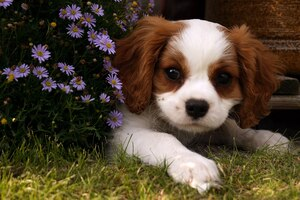

In [ ]:
fn = Path('./samples/puppy.jpg')
display.Image(filename=fn, width=200)

Now that we are passing more than just text, will need a helper function to upload media using Gemini's File API, which is the recomended way of passing media to the model.

In [ ]:
#| exports
def media_msg(fn: Path)->dict:
    if isinstance(fn, dict): return fn # Already processed
    f = genai.upload_file(fn)
    return {'file_data': {'mime_type': f.mime_type, 'file_uri': f.uri}}

Let's also update how we pass in text type messages, to be consistent

In [ ]:
#| exports
def text_msg(s:str)->dict:
    return {'text': s}

And finally lets add a helper function for make content correctly handles text and other media.

In [ ]:
#| exports
def _mk_content(src):
    "Create appropriate content data structure based on type of content"
    if isinstance(src,str): return text_msg(src)
    if isinstance(src,FunctionResponse): return src
    else: return media_msg(src)

Now let's make sure it properly handles text vs. Path objects for media

In [ ]:
_mk_content("Hi")

{'text': 'Hi'}

In [ ]:
_mk_content(fn)

{'file_data': {'mime_type': 'image/jpeg',
  'file_uri': 'https://generativelanguage.googleapis.com/v1beta/files/zpoa38voejtt'}}

And now we need to update mk_msg to be able to handle multimedia messages correctly.

In [ ]:
#| exports
def mk_msg(content, role='user', **kw):
    if isinstance(content, GenerateContentResponse): role,content = 'model',contents(content)
    if isinstance(content, dict): role,content = content['role'],content['parts']
    if not isinstance(content, list): content=[content]
    if role == 'user': 
        if content: ## Gemini errors if the message contains only media and no text
            if len(content) == 1 and not isinstance(content[0], str): content.append(' ')
            content = [_mk_content(o) for o in content]
        else: content = ''
    return dict(role=role, parts=content, **kw)

In [ ]:
#| exports
def mk_msgs(msgs:list, **kw):
    "Helper to set 'assistant' role on alternate messages."
    if isinstance(msgs,str): msgs=[msgs]
    return [mk_msg(o, ('user','model')[i%2], **kw) for i,o in enumerate(msgs)]

In [ ]:
q = "In brief, what color flowers are in this image?"
mk_msgs([fn, q])

[{'role': 'user',
  'parts': [{'file_data': {'mime_type': 'image/jpeg',
     'file_uri': 'https://generativelanguage.googleapis.com/v1beta/files/kmbr0020l5k6'}},
   {'text': ' '}]},
 {'role': 'model',
  'parts': ['In brief, what color flowers are in this image?']}]

In [ ]:
mk_msgs(['Hi', 'Nice, to meet you. How can I help?', [fn, q]])

[{'role': 'user', 'parts': [{'text': 'Hi'}]},
 {'role': 'model', 'parts': ['Nice, to meet you. How can I help?']},
 {'role': 'user',
  'parts': [{'file_data': {'mime_type': 'image/jpeg',
     'file_uri': 'https://generativelanguage.googleapis.com/v1beta/files/sfxeop0j911a'}},
   {'text': 'In brief, what color flowers are in this image?'}]}]

Now, we should just be able to pass a list of multimedia content to our Chat client and it should be able to handle it all under the hood. Let's test it out.

In [ ]:
chat(fn)

This picture features an adorable Cavalier King Charles Spaniel puppy. It has beautiful brown and white fur, and is resting on a grassy area next to a patch of purple flowers. The puppy is looking directly at the camera with a sweet expression.

<details>

- content: {'parts': [{'text': 'This picture features an adorable Cavalier King Charles Spaniel puppy. It has beautiful brown and white fur, and is resting on a grassy area next to a patch of purple flowers. The puppy is looking directly at the camera with a sweet expression.\n'}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -0.6654894303302376
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 1183
- candidates_token_count: 49
- total_token_count: 1232
- cached_content_token_count: 0

</details>

In [ ]:
chat([fn, q])

The flowers in the image are purple.

<details>

- content: {'parts': [{'text': 'The flowers in the image are purple.\n'}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -0.011526683138476478
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 913
- candidates_token_count: 9
- total_token_count: 922
- cached_content_token_count: 0

</details>

Hooray! That works, let's double check the history to make sure that everything is properly formatted and stored.

In [ ]:
mk_msgs(chat.h)

[{'role': 'user',
  'parts': [{'file_data': {'mime_type': 'image/jpeg',
     'file_uri': 'https://generativelanguage.googleapis.com/v1beta/files/y1u2m1yaahq'}},
   {'text': ' '}]},
 {'role': 'model',
  'parts': ["This is an adorable image! The puppy is a Cavalier King Charles Spaniel with a beautiful coat of white and chestnut brown. It's nestled amongst some lovely purple flowers and green grass. The puppy's big, dark eyes and sweet expression make it irresistibly cute."]},
 {'role': 'user',
  'parts': [{'file_data': {'mime_type': 'image/jpeg',
     'file_uri': 'https://generativelanguage.googleapis.com/v1beta/files/xpvi2ey0087o'}},
   {'text': ' '}]},
 {'role': 'model',
  'parts': ['The image shows a charming Cavalier King Charles Spaniel puppy, with its distinctive white and chestnut coat, positioned amidst some blooming purple flowers. The pup is resting on the grass, and its gaze is directed towards the viewer. Its soft fur and gentle expression evoke a sense of warmth and tendern

While we are at it, let's update our markdown representation to handle the new messages.

In [ ]:
#| exports
@patch
def _repr_markdown_(self:Chat):
    if not hasattr(self.c, 'result'): return 'No results yet'
    last_msg = contents(self.c.result)
    
    def fmt_part(ps):
        if len(ps) == 1: return fmt_single(ps[0])
        return '\n' + '\n'.join(f'- {fmt_single(p)}' for p in ps)
        
    def fmt_single(p):
        if 'text' in p: return p['text']
        if 'file_data' in p: return f"uploaded media: {p['file_data']['mime_type']}"
        return str(p)
        
    history = '\n\n'.join(f"**{m['role']}**: {fmt_part(m['parts'])}" 
                         for m in self.h if m['role'] in ('user','model'))
    det = self.c._repr_markdown_().split('\n\n')[-1]
    return f"""{last_msg}

<details>
<summary>History</summary>

{history}
</details>
{det}"""

In [ ]:
chat

The flowers in the image are **purple**.

<details>
<summary>History</summary>

**user**: 
- uploaded media: image/jpeg
- In brief, what color flowers are in this image?

**model**: The flowers in the image are **purple**.
</details>
| Metric | Count | Cost (USD) |
|--------|------:|-----:|
| Input tokens | 270 | 0.000000 |
| Output tokens | 9 | 0.000000 |
| Cache tokens | 0 | 0.000000 |
| **Total** | **279** | **$0.000000** |

## Other Media (audio, video, etc.)

Unlike ChatGPT and Claude, Gemini models can also handle audio and video inputs. Since we're using Gemini's File API for handling multimedia content, what we have should just work, except we'll need to make one small modification to the `media_msg` function. Also, while we are at it, let us also allow for users to pass in the bytes of the content instead of the path to be consistent with our other LLM provider libraries.

In [ ]:
#| exports 
def media_msg(
    media, # Media to process (Path|bytes|dict)
    mime=None # Optional mime type
)->dict: # Dict for Gemini API
    "Handle media input as either Path or bytes, returning dict for Gemini API"
    if isinstance(media, dict): return media # Already processed
    def _upload(f, mime=None):
        f = genai.upload_file(f, mime_type=mime)
        while f.state.name == "PROCESSING": time.sleep(2); f = genai.get_file(f.name)
        return {'file_data': {'mime_type': f.mime_type, 'file_uri': f.uri}}
    if isinstance(media, (str,Path)): return _upload(media)
    if isinstance(media, bytes) and mime is None: mime = ft.guess(media).mime
    return _upload(io.BytesIO(media if isinstance(media, bytes) else media.encode()), mime)

Since we're uploading potentially larger files, we need to wait for the upload and process to complete so that the media is ready to be consumed by the model.

In [ ]:
chat = Chat(model)
img = fn.read_bytes()

In [ ]:
chat([img, q])

Certainly! The flowers in the image are a light purple color.
<details>

- content: {'parts': [{'text': 'Certainly! The flowers in the image are a light purple color.'}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -0.45572607333843523
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 270
- candidates_token_count: 13
- total_token_count: 283
- cached_content_token_count: 0

</details>

In [ ]:
# We'll test this with the example from Gemini's docs
video_fn = Path('./samples/selective_attention_test.mp4')
prompt = "Answer the question in the video"

In [ ]:
chat = Chat(model)
chat([video_fn, prompt])

The players wearing white pass the basketball 13 times.
<details>

- content: {'parts': [{'text': 'The players wearing white pass the basketball 13 times.'}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -0.4509180386861165
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 10527
- candidates_token_count: 12
- total_token_count: 10539
- cached_content_token_count: 0

</details>

Takes a little while, but works like a charm! Now, let's try an audio file to make sure it also works.

In [ ]:
audio_fn = Path('./samples/attention_is_all_you_need.mp3')
audio = audio_fn.read_bytes()
prompt = "What is the audio about?"

In [ ]:
chat([audio, prompt])

The audio is a podcast discussion about a groundbreaking research paper titled "Attention is All You Need" by Vaswani et al. The podcast features a machine learning expert who explains the core ideas, motivation, and architecture of the Transformer model introduced in the paper. They discuss the significance of attention mechanisms, how the Transformer differs from previous approaches like RNNs, its remarkable performance on machine translation and other sequence transduction tasks, and the broader implications of the research for machine learning and NLP. They also touch upon the limitations and future directions.
<details>

- content: {'parts': [{'text': 'The audio is a podcast discussion about a groundbreaking research paper titled "Attention is All You Need" by Vaswani et al. The podcast features a machine learning expert who explains the core ideas, motivation, and architecture of the Transformer model introduced in the paper. They discuss the significance of attention mechanisms, how the Transformer differs from previous approaches like RNNs, its remarkable performance on machine translation and other sequence transduction tasks, and the broader implications of the research for machine learning and NLP. They also touch upon the limitations and future directions.'}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -0.48403912498837426
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 18387
- candidates_token_count: 105
- total_token_count: 18492
- cached_content_token_count: 0

</details>

Finally, let's check to make sure pdfs work as well.

In [ ]:
pdf_fn = Path('./samples/attention_is_all_you_need.pdf')
prompt = "What's mentioned in this pdf that's not mentioned in the previous podcast?"
chat([pdf_fn, prompt])

Okay, here's a breakdown of what's in the PDF that wasn't covered in the podcast:

**Technical Details of the Transformer:**

*   **Detailed Architecture:** The PDF provides a much more detailed breakdown of the Transformer architecture, including the specific arrangement of encoder and decoder layers, sub-layers, residual connections, and layer normalization (see Figure 1 and Section 3.1). The podcast gave a high-level overview, whereas the PDF is more specific about the components used to build the model.

*   **Scaled Dot-Product Attention:** The document explains the mechanics of "Scaled Dot-Product Attention" (section 3.2.1, Figure 2), and its advantages over additive attention and specifically mentions that dot products are scaled by  `1/sqrt(dk)`. This isn't mentioned in the podcast.

*   **Multi-Head Attention:** The PDF delves into the purpose of "Multi-Head Attention", stating that it enables the model to attend to different representation subspaces (section 3.2.2, Figure 2). It also explicitly states that the projections are parameter matrices such as `WQ ∈ R^(d_model x d_k), WK ∈ R^(d_model x d_k)`, etc.. and gives the values for the number of attention layers used. The podcast explained what multi-head attention was, but didn't delve into the math or specific values used.
*   **Positional Encodings:** The PDF describes the specific sine and cosine functions used for positional encoding (section 3.5) and why they chose this method. This level of detail about this topic isn't mentioned in the podcast.

*   **Point-wise Feed-Forward Networks:** The podcast doesn't go into the details of this topic, but the PDF notes that feed-forward networks in each layer are position-wise, fully connected, and consist of two linear transformations with a ReLU activation in between. It also specifies the dimensionality of input and output as well as the inner layer (section 3.3).

*   **Embeddings and Softmax:** The PDF states how learned embeddings are used to convert input/output tokens to vectors (section 3.4), and that the same weight matrix is shared between embeddings and the pre-softmax linear transformation. The embeddings are multiplied by the square root of d_model. These details are not mentioned in the podcast.

**Training and Evaluation:**

*   **Training Details:** The PDF explains the datasets (WMT 2014 English-German and English-French), the use of byte-pair encoding and word-piece vocabularies, and batching based on approximate sequence lengths (section 5.1). It also specifies how the model is trained using a specific number of training steps, using GPUs, the Adam optimizer and a specific formula for varying the learning rate (sections 5.2, 5.3). The podcast briefly mentions training time, but doesn't give specific dataset, architecture, or learning details.
*   **Regularization:** The PDF explicitly mentions the use of residual dropout and label smoothing during training and the parameters used (section 5.4). The podcast didn't discuss this at all.
*   **Performance Metrics:** The PDF presents specific BLEU scores for various models on the English-German and English-French translation tasks and lists the training cost in FLOPS (section 6.1, Table 2). It also mentions beam search details like beam size and a length penalty. The podcast only mentions the end results of BLEU score.
*   **Model Variations:** The PDF explores various variations of the base model (section 6.2, Table 3), testing different parameters (number of heads, key/value dimensions, dropout rates, etc.), and mentions which variations performed well or poorly. The podcast doesn't mention any of these experiments.
*   **English Constituency Parsing Results:** The PDF mentions that the transformer performs well on english constituency parsing with results from the Penn Treebank (section 6.3, Table 4) and compares its results against other models. This is only briefly touched on in the podcast, and none of the results from this section is covered.

**Other Points**

*   **Computational Complexity Analysis:** The PDF includes a table (Table 1) that compares the computational complexity, sequential operations and maximum path lengths of self-attention, recurrent and convolutional layers. This is not covered in the podcast.
*   **Attention Visualizations:** The PDF includes visualization examples of attention heads for certain words (Figure 3, 4, and 5), showcasing the behavior and long range dependencies. These visualizations are not shown nor covered in the podcast.
*   **References and Acknowledgements:** The document has a complete list of references and acknowledgements. This was not part of the podcast.

**In summary, while the podcast provided a good overview, the PDF offers a deeper technical dive into the Transformer model, along with details about its training, experiments, and evaluations that aren't touched upon in the audio discussion.** The PDF provides specifics that an audience interested in implementing the model or performing experiments would be interested in.

<details>

- content: {'parts': [{'text': 'Okay, here\'s a breakdown of what\'s in the PDF that wasn\'t covered in the podcast:\n\n**Technical Details of the Transformer:**\n\n*   **Detailed Architecture:** The PDF provides a much more detailed breakdown of the Transformer architecture, including the specific arrangement of encoder and decoder layers, sub-layers, residual connections, and layer normalization (see Figure 1 and Section 3.1). The podcast gave a high-level overview, whereas the PDF is more specific about the components used to build the model.\n\n*   **Scaled Dot-Product Attention:** The document explains the mechanics of "Scaled Dot-Product Attention" (section 3.2.1, Figure 2), and its advantages over additive attention and specifically mentions that dot products are scaled by  `1/sqrt(dk)`. This isn\'t mentioned in the podcast.\n\n*   **Multi-Head Attention:** The PDF delves into the purpose of "Multi-Head Attention", stating that it enables the model to attend to different representation subspaces (section 3.2.2, Figure 2). It also explicitly states that the projections are parameter matrices such as `WQ ∈ R^(d_model x d_k), WK ∈ R^(d_model x d_k)`, etc.. and gives the values for the number of attention layers used. The podcast explained what multi-head attention was, but didn\'t delve into the math or specific values used.\n*   **Positional Encodings:** The PDF describes the specific sine and cosine functions used for positional encoding (section 3.5) and why they chose this method. This level of detail about this topic isn\'t mentioned in the podcast.\n\n*   **Point-wise Feed-Forward Networks:** The podcast doesn\'t go into the details of this topic, but the PDF notes that feed-forward networks in each layer are position-wise, fully connected, and consist of two linear transformations with a ReLU activation in between. It also specifies the dimensionality of input and output as well as the inner layer (section 3.3).\n\n*   **Embeddings and Softmax:** The PDF states how learned embeddings are used to convert input/output tokens to vectors (section 3.4), and that the same weight matrix is shared between embeddings and the pre-softmax linear transformation. The embeddings are multiplied by the square root of d_model. These details are not mentioned in the podcast.\n\n**Training and Evaluation:**\n\n*   **Training Details:** The PDF explains the datasets (WMT 2014 English-German and English-French), the use of byte-pair encoding and word-piece vocabularies, and batching based on approximate sequence lengths (section 5.1). It also specifies how the model is trained using a specific number of training steps, using GPUs, the Adam optimizer and a specific formula for varying the learning rate (sections 5.2, 5.3). The podcast briefly mentions training time, but doesn\'t give specific dataset, architecture, or learning details.\n*   **Regularization:** The PDF explicitly mentions the use of residual dropout and label smoothing during training and the parameters used (section 5.4). The podcast didn\'t discuss this at all.\n*   **Performance Metrics:** The PDF presents specific BLEU scores for various models on the English-German and English-French translation tasks and lists the training cost in FLOPS (section 6.1, Table 2). It also mentions beam search details like beam size and a length penalty. The podcast only mentions the end results of BLEU score.\n*   **Model Variations:** The PDF explores various variations of the base model (section 6.2, Table 3), testing different parameters (number of heads, key/value dimensions, dropout rates, etc.), and mentions which variations performed well or poorly. The podcast doesn\'t mention any of these experiments.\n*   **English Constituency Parsing Results:** The PDF mentions that the transformer performs well on english constituency parsing with results from the Penn Treebank (section 6.3, Table 4) and compares its results against other models. This is only briefly touched on in the podcast, and none of the results from this section is covered.\n\n**Other Points**\n\n*   **Computational Complexity Analysis:** The PDF includes a table (Table 1) that compares the computational complexity, sequential operations and maximum path lengths of self-attention, recurrent and convolutional layers. This is not covered in the podcast.\n*   **Attention Visualizations:** The PDF includes visualization examples of attention heads for certain words (Figure 3, 4, and 5), showcasing the behavior and long range dependencies. These visualizations are not shown nor covered in the podcast.\n*   **References and Acknowledgements:** The document has a complete list of references and acknowledgements. This was not part of the podcast.\n\n**In summary, while the podcast provided a good overview, the PDF offers a deeper technical dive into the Transformer model, along with details about its training, experiments, and evaluations that aren\'t touched upon in the audio discussion.** The PDF provides specifics that an audience interested in implementing the model or performing experiments would be interested in.\n'}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -0.8560131542336379
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 33441
- candidates_token_count: 1081
- total_token_count: 34522
- cached_content_token_count: 0

</details>

Gemini does a pretty good job here!!

In [ ]:
pr = "Can you generate an exact transcript of the first minute or so of the podcast."
chat(pr)

Okay, here's the transcript of the first minute of the podcast, based on your request:

"Welcome to our podcast, where we dive into groundbreaking research papers. Today, we're discussing 'Attention is All You Need' by Vaswani et al. Joining us is an expert in machine learning. Welcome. Thanks for having me. I'm excited to discuss this revolutionary paper. Let's start with the core idea. What's the main thrust of this research? The paper introduces a new model architecture called the Transformer, which is based entirely on attention mechanisms. It completely does away with recurrence and convolutions, which were staples in previous sequence transduction models. That sounds like a significant departure from previous approaches. What motivated this radical change? The main motivation was to address limitations in previous models, particularly the sequential nature of processing in RNNs. This sequential computation hindered parallelization and made it challenging to learn long-range dependencies in sequences. Could you explain what attention mechanisms are and why they're so crucial in this model? Certainly. Attention allows the model to focus on different parts of the input sequence when producing each part of the output. In the Transformer, they use a specific type called scaled dot product attention and extend it to multi head attention, which lets the model jointly attend to information from different representation sub spaces. Fascinating."

<details>

- content: {'parts': [{'text': 'Okay, here\'s the transcript of the first minute of the podcast, based on your request:\n\n"Welcome to our podcast, where we dive into groundbreaking research papers. Today, we\'re discussing \'Attention is All You Need\' by Vaswani et al. Joining us is an expert in machine learning. Welcome. Thanks for having me. I\'m excited to discuss this revolutionary paper. Let\'s start with the core idea. What\'s the main thrust of this research? The paper introduces a new model architecture called the Transformer, which is based entirely on attention mechanisms. It completely does away with recurrence and convolutions, which were staples in previous sequence transduction models. That sounds like a significant departure from previous approaches. What motivated this radical change? The main motivation was to address limitations in previous models, particularly the sequential nature of processing in RNNs. This sequential computation hindered parallelization and made it challenging to learn long-range dependencies in sequences. Could you explain what attention mechanisms are and why they\'re so crucial in this model? Certainly. Attention allows the model to focus on different parts of the input sequence when producing each part of the output. In the Transformer, they use a specific type called scaled dot product attention and extend it to multi head attention, which lets the model jointly attend to information from different representation sub spaces. Fascinating."\n'}], 'role': 'model'}
- finish_reason: 1
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- avg_logprobs: -0.07141794775524278
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 34540
- candidates_token_count: 274
- total_token_count: 34814
- cached_content_token_count: 0

</details>

In [ ]:
chat

Okay, here's the transcript of the first minute of the podcast, based on your request:

"Welcome to our podcast, where we dive into groundbreaking research papers. Today, we're discussing 'Attention is All You Need' by Vaswani et al. Joining us is an expert in machine learning. Welcome. Thanks for having me. I'm excited to discuss this revolutionary paper. Let's start with the core idea. What's the main thrust of this research? The paper introduces a new model architecture called the Transformer, which is based entirely on attention mechanisms. It completely does away with recurrence and convolutions, which were staples in previous sequence transduction models. That sounds like a significant departure from previous approaches. What motivated this radical change? The main motivation was to address limitations in previous models, particularly the sequential nature of processing in RNNs. This sequential computation hindered parallelization and made it challenging to learn long-range dependencies in sequences. Could you explain what attention mechanisms are and why they're so crucial in this model? Certainly. Attention allows the model to focus on different parts of the input sequence when producing each part of the output. In the Transformer, they use a specific type called scaled dot product attention and extend it to multi head attention, which lets the model jointly attend to information from different representation sub spaces. Fascinating."


<details>
<summary>History</summary>

**user**: 
- uploaded media: video/mp4
- Answer the question in the video

**model**: The players wearing white pass the basketball 13 times.

**user**: 
- uploaded media: audio/mpeg
- What is the audio about?

**model**: The audio is a podcast discussion about a groundbreaking research paper titled "Attention is All You Need" by Vaswani et al. The podcast features a machine learning expert who explains the core ideas, motivation, and architecture of the Transformer model introduced in the paper. They discuss the significance of attention mechanisms, how the Transformer differs from previous approaches like RNNs, its remarkable performance on machine translation and other sequence transduction tasks, and the broader implications of the research for machine learning and NLP. They also touch upon the limitations and future directions.

**user**: 
- uploaded media: application/pdf
- What's mentioned in this pdf that's not mentioned in the previous podcast?

**model**: Okay, here's a breakdown of what's in the PDF that wasn't covered in the podcast:

**Technical Details of the Transformer:**

*   **Detailed Architecture:** The PDF provides a much more detailed breakdown of the Transformer architecture, including the specific arrangement of encoder and decoder layers, sub-layers, residual connections, and layer normalization (see Figure 1 and Section 3.1). The podcast gave a high-level overview, whereas the PDF is more specific about the components used to build the model.

*   **Scaled Dot-Product Attention:** The document explains the mechanics of "Scaled Dot-Product Attention" (section 3.2.1, Figure 2), and its advantages over additive attention and specifically mentions that dot products are scaled by  `1/sqrt(dk)`. This isn't mentioned in the podcast.

*   **Multi-Head Attention:** The PDF delves into the purpose of "Multi-Head Attention", stating that it enables the model to attend to different representation subspaces (section 3.2.2, Figure 2). It also explicitly states that the projections are parameter matrices such as `WQ ∈ R^(d_model x d_k), WK ∈ R^(d_model x d_k)`, etc.. and gives the values for the number of attention layers used. The podcast explained what multi-head attention was, but didn't delve into the math or specific values used.
*   **Positional Encodings:** The PDF describes the specific sine and cosine functions used for positional encoding (section 3.5) and why they chose this method. This level of detail about this topic isn't mentioned in the podcast.

*   **Point-wise Feed-Forward Networks:** The podcast doesn't go into the details of this topic, but the PDF notes that feed-forward networks in each layer are position-wise, fully connected, and consist of two linear transformations with a ReLU activation in between. It also specifies the dimensionality of input and output as well as the inner layer (section 3.3).

*   **Embeddings and Softmax:** The PDF states how learned embeddings are used to convert input/output tokens to vectors (section 3.4), and that the same weight matrix is shared between embeddings and the pre-softmax linear transformation. The embeddings are multiplied by the square root of d_model. These details are not mentioned in the podcast.

**Training and Evaluation:**

*   **Training Details:** The PDF explains the datasets (WMT 2014 English-German and English-French), the use of byte-pair encoding and word-piece vocabularies, and batching based on approximate sequence lengths (section 5.1). It also specifies how the model is trained using a specific number of training steps, using GPUs, the Adam optimizer and a specific formula for varying the learning rate (sections 5.2, 5.3). The podcast briefly mentions training time, but doesn't give specific dataset, architecture, or learning details.
*   **Regularization:** The PDF explicitly mentions the use of residual dropout and label smoothing during training and the parameters used (section 5.4). The podcast didn't discuss this at all.
*   **Performance Metrics:** The PDF presents specific BLEU scores for various models on the English-German and English-French translation tasks and lists the training cost in FLOPS (section 6.1, Table 2). It also mentions beam search details like beam size and a length penalty. The podcast only mentions the end results of BLEU score.
*   **Model Variations:** The PDF explores various variations of the base model (section 6.2, Table 3), testing different parameters (number of heads, key/value dimensions, dropout rates, etc.), and mentions which variations performed well or poorly. The podcast doesn't mention any of these experiments.
*   **English Constituency Parsing Results:** The PDF mentions that the transformer performs well on english constituency parsing with results from the Penn Treebank (section 6.3, Table 4) and compares its results against other models. This is only briefly touched on in the podcast, and none of the results from this section is covered.

**Other Points**

*   **Computational Complexity Analysis:** The PDF includes a table (Table 1) that compares the computational complexity, sequential operations and maximum path lengths of self-attention, recurrent and convolutional layers. This is not covered in the podcast.
*   **Attention Visualizations:** The PDF includes visualization examples of attention heads for certain words (Figure 3, 4, and 5), showcasing the behavior and long range dependencies. These visualizations are not shown nor covered in the podcast.
*   **References and Acknowledgements:** The document has a complete list of references and acknowledgements. This was not part of the podcast.

**In summary, while the podcast provided a good overview, the PDF offers a deeper technical dive into the Transformer model, along with details about its training, experiments, and evaluations that aren't touched upon in the audio discussion.** The PDF provides specifics that an audience interested in implementing the model or performing experiments would be interested in.


**user**: Can you generate an exact transcript of the first minute or so of the podcast.

**model**: Okay, here's the transcript of the first minute of the podcast, based on your request:

"Welcome to our podcast, where we dive into groundbreaking research papers. Today, we're discussing 'Attention is All You Need' by Vaswani et al. Joining us is an expert in machine learning. Welcome. Thanks for having me. I'm excited to discuss this revolutionary paper. Let's start with the core idea. What's the main thrust of this research? The paper introduces a new model architecture called the Transformer, which is based entirely on attention mechanisms. It completely does away with recurrence and convolutions, which were staples in previous sequence transduction models. That sounds like a significant departure from previous approaches. What motivated this radical change? The main motivation was to address limitations in previous models, particularly the sequential nature of processing in RNNs. This sequential computation hindered parallelization and made it challenging to learn long-range dependencies in sequences. Could you explain what attention mechanisms are and why they're so crucial in this model? Certainly. Attention allows the model to focus on different parts of the input sequence when producing each part of the output. In the Transformer, they use a specific type called scaled dot product attention and extend it to multi head attention, which lets the model jointly attend to information from different representation sub spaces. Fascinating."

</details>

| Metric | Count | Cost (USD) |
|--------|------:|-----:|
| Input tokens | 96,895 | 0.000000 |
| Output tokens | 1,472 | 0.000000 |
| Cache tokens | 0 | 0.000000 |
| **Total** | **98,367** | **$0.000000** |

All of these also work with `Client` and can be combined with `structured` to get structured responses using multi-media data.

In [ ]:
class AudioMetadata(BasicRepr):
    """Class to hold metadata for audio files"""
    def __init__(
        self,
        n_speakers:int, # Number of speakers
        topic:str, # Topic discussed
        summary:str, # 100 word summary
        transcript:list[str], # Transcript of the audio segmented by speaker
    ): store_attr()
pr = "Extract the necessary information from the audio."

In [ ]:
c = Client(model)
audio_md = c.structured(mk_msgs([[audio_fn, pr]]), tools=[AudioMetadata])[0]

In [ ]:
print(f'Number of speakers: {audio_md.n_speakers}')
print(f'Topic: {audio_md.topic}')
print(f'Summary: {audio_md.summary}')
transcript = '\n-'.join(list(audio_md.transcript)[:10])
print(f'Transcript: {transcript}')

Number of speakers: 2.0
Topic: Machine Learning, Natural Language Processing
Summary: This podcast discusses the Attention is All You Need research paper, focusing on the Transformer model's architecture, attention mechanisms, performance, and broader implications.
Transcript: Welcome to our podcast, where we dive into groundbreaking research papers. Today, we're discussing attention is all you need by Vaswani at all. Joining us is an expert in machine learning. Welcome.
-Thanks for having me. I'm excited to discuss this revolutionary paper.
-Let's start with the core idea. What's the main thrust of this research?
-The paper introduces a new model architecture called the Transformer, which is based entirely on attention mechanisms. It completely does away with recurrence and convolutions, which were staples in previous sequence transduction models.
-That sounds like a significant departure from previous approaches. What motivated this radical change?
-The main motivation was to address

## Export -

In [ ]:
#|hide
#|eval: false
from nbdev.doclinks import nbdev_export
nbdev_export()